# Summary

```Objective```

Inject Rotation, Translation, Artifact, and Deformation to images.

```Methods```

Use the function in torchio.RandomAffine, torchio.RandomMotion, torchio.RandomElasticDeformation

```Results```

todo

# Config

# Libs

In [2]:
import numpy as np
import torch
import torchio as tio
import torchio.transforms as transforms
import matplotlib.pyplot as plt
import h5py
import math
import nibabel as nib
from scipy.fft import fftn, ifftn, fftshift, ifftshift
from misalign.data.IXI_datamodule import IXIDataModule
from misalign.draw import blend_and_transpose
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

def show_img(img):
    plt.figure(dpi=150)
    im = plt.imshow(img, cmap='gray')
    # cbar = plt.colorbar(im, shrink=0.5)
    im.set_clim(vmin=-1, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Analysis

### 1. Load Raw data

In [3]:
def show_blended(img):
    plt.figure(dpi=150)
    im = plt.imshow(img, cmap='gray')
    im.set_clim(vmin=0, vmax=0.5)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def show_T1(img):
    plt.figure(dpi=150)
    im = plt.imshow(img, cmap='gray')
    # cbar = plt.colorbar(im, shrink=0.5)
    im.set_clim(vmin=0, vmax=120)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def show_T2(img):
    plt.figure(dpi=150)
    im = plt.imshow(img, cmap='gray')
    # cbar = plt.colorbar(im, shrink=0.5)
    im.set_clim(vmin=0, vmax=200)
    plt.xticks([])
    plt.yticks([])
    plt.show()

data size: (256, 256, 91)


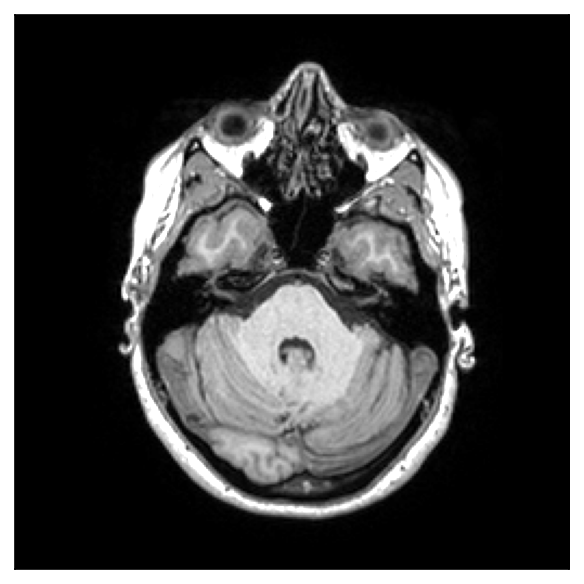

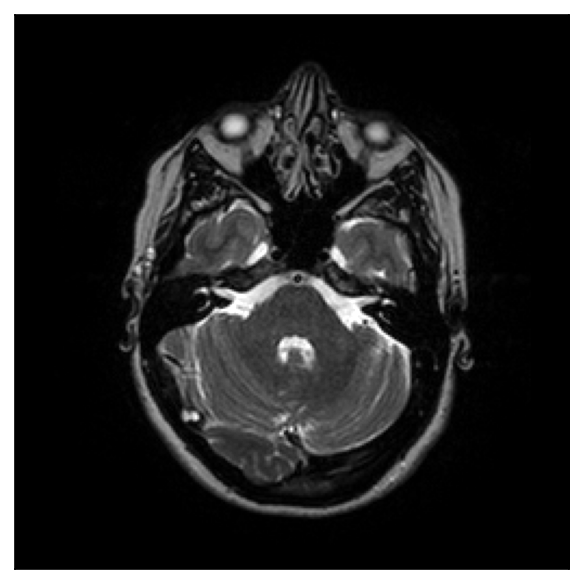

In [45]:
dataroot = 'C:/Users/NUGURI/Workspace/2023.08.12_misalign_REG/logs/Model_proposed_A_to_B_Data_IXI_Misalign_X0_Y0_R0_M0_D0/Proposed_100_5_100_120_lv0_T1/runs/2023-08-13_02-26-54/results/b_6.nii.gz'
nii_img = nib.load(dataroot)
T1_data = nii_img.get_fdata()
T1_data = np.transpose(T1_data, (1,0,2))  # Axial:1,0,2  /  Saggital:2,1,0
T1_data = np.flipud(T1_data)
T1_data = np.fliplr(T1_data)

dataroot = 'C:/Users/NUGURI/Workspace/2023.08.12_misalign_REG/logs/Model_proposed_A_to_B_Data_IXI_Misalign_X0_Y0_R0_M0_D0/Proposed_100_5_100_120_lv0_T1/runs/2023-08-13_02-26-54/results/a_6.nii.gz'
nii_img = nib.load(dataroot)
T2_data = nii_img.get_fdata()
T2_data = np.transpose(T2_data, (1,0,2))  # Axial:1,0,2  /  Saggital:2,1,0
T2_data = np.flipud(T2_data)
T2_data = np.fliplr(T2_data)

test_dataroot = 'C:/Users/NUGURI/Workspace/2023.08.22_misalign_CBM/logs/Model_proposed_A_to_B_Data_Split_3T1_7T1_Misalign_X0_Y0_R0_M0_D0/RW_CX_100_5_100_lv0_3T1_7T1_s/runs/2023-08-24_21-40-16/results/b_1.nii.gz'
nii_img = nib.load(test_dataroot)
test_data = nii_img.get_fdata()
test_data = np.transpose(test_data, (1,0,2))  # Axial:1,0,2  /  Saggital:2,1,0
test_data = np.flipud(test_data)
test_data = np.fliplr(test_data)

print('data size:', T2_data.shape)

zz = 13 - 1

zz1 = 20-1
zz2 = 80-1

# ssim_value = compare_ssim(T1_data[:,:,zz1:zz2], test_data[:,:,zz1:zz2], data_range=T1_data[:,:,zz1:zz2].max() - T1_data[:,:,zz1:zz2].min())
# psnr_value = compare_psnr(T1_data[:,:,zz1:zz2], test_data[:,:,zz1:zz2], data_range=T1_data[:,:,zz1:zz2].max() - T1_data[:,:,zz1:zz2].min())
# print(ssim_value)
# print(psnr_value)

show_T1(T1_data[:,:,zz])
show_T2(T2_data[:,:,zz])
# show_T1(test_data[:,:,zz])

### 2. Random Affine (z-Rotation, y-Translation)

In [ ]:
torch.manual_seed(123)
mul = 5

s_transform = tio.RandomAffine(
    scales =0,
    degrees=(0,0,0,0,0,0),  # z-axis 2D-Rotation range in degrees. (0,0,0,0,-5,-5)
    translation=(0,0,0,0,0,0),  # (0,0,-5,-5,0,0)
    default_pad_value = 'otsu',  # edge control, fill value is the mean of the values at the border that lie under an Otsu threshold.
)

t_transform = tio.RandomAffine(
    scales =0,
    degrees=(0,0,0,0,-1*mul,-1*mul),  # z-axis 2D-Rotation range in degrees. (0,0,0,0,5,5)
    translation=(0,0,2*mul,2*mul,0,0),  # (0,0,5,5,0,0)
    default_pad_value = 'otsu',  # edge control, fill value is the mean of the values at the border that lie under an Otsu threshold.
)

tmp_T1 = np.expand_dims(T1_data, axis=0)
tmp_T2 = np.expand_dims(T2_data, axis=0)
transformed_T1 = np.array(s_transform(tmp_T1.copy()).squeeze())
transformed_T2 = np.array(t_transform(tmp_T2.copy()).squeeze())

blended_image = np.zeros((256, 256, 3))
blended_image[:, :, 0] = transformed_T1[:,:,zz]*0.7/150
blended_image[:, :, 1] = transformed_T1[:,:,zz]*0.3/150
blended_image[:, :, 2] = transformed_T2[:,:,zz]/150

show_T1(transformed_T1[:,:,zz])
show_T2(transformed_T2[:,:,zz])
show_blended(blended_image)

### 3. Random 3D-Motion Artifact

In [26]:
def JHL_prob(raw_img, motion_img, prob):
    assert (
        prob >= 0
    ), "prob must have zero or positive value"

    raw_k = fftshift(fftn(raw_img))
    motion_k = fftshift(fftn(motion_img))
    diff = math.ceil(2.56*prob)

    raw_k[:,128-diff : 128,:] = motion_k[:,128-diff : 128,:]

    res = abs(ifftn(ifftshift(raw_k)))
    return res

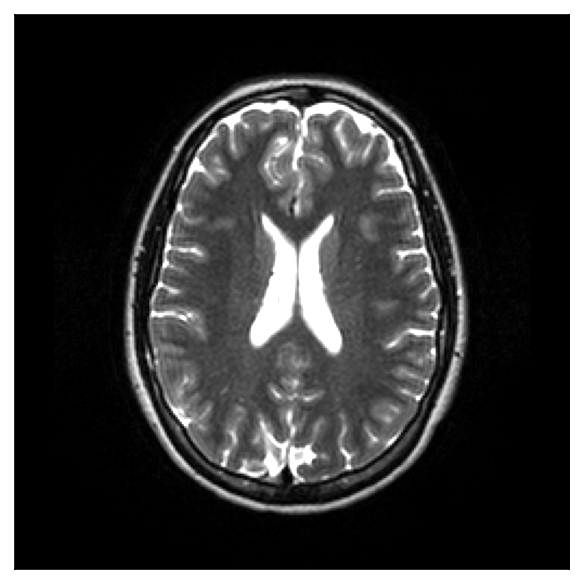

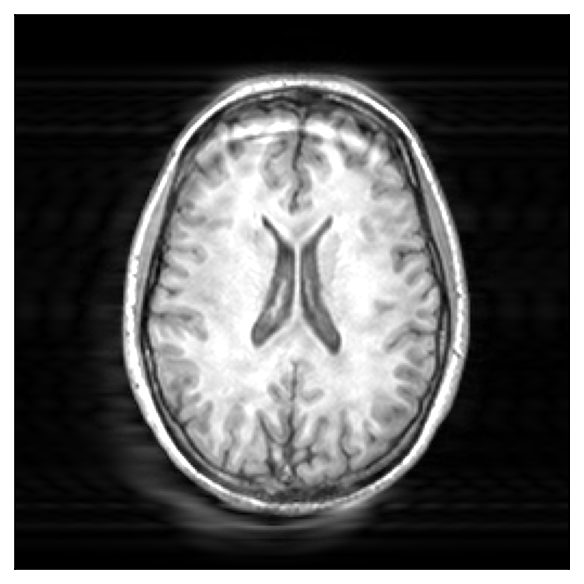

In [35]:
# torch.manual_seed(121)
# Define the 3D-RandomMotion transform
random_motion = tio.RandomMotion(
    degrees=(5,5),              # Maximum rotation angle in degrees [10,10]
    translation=(5,5),         # Maximum translation in mm [20,20]
    num_transforms=20       # Number of motion transformations to apply 20
)

tmp1 = np.expand_dims(T1_data.copy(), axis=0)
tmp2 = np.expand_dims(T2_data.copy(), axis=0)

Motion_T1 = random_motion(tmp1).squeeze()
Motion_T2 = random_motion(tmp2).squeeze()

Motion_T1_prob = JHL_prob(T1_data, Motion_T1, prob=6)  # prob=6
Motion_T2_prob = JHL_prob(T2_data, Motion_T2, prob=6)  # prob=6

# residual_T1 = np.zeros((256, 256, 910))
# residual_T1 = abs(T1_data - Motion_T1_prob)

# residual_T2 = np.zeros((256, 256, 910))
# residual_T2 = abs(T2_data - Motion_T2_prob)

# blended_image = np.zeros((304, 256, 3))
# blended_image[:, :, 0] = T1_data[:,:,zz]*0.7/150
# blended_image[:, :, 1] = T1_data[:,:,zz]*0.3/150
# blended_image[:, :, 2] = Motion_T2_prob[:,:,zz]/150 + residual_T2[:,:,zz]/150

show_T1(T1_data[:,:,zz])
show_T1(Motion_T1_prob[:,:,zz])
# show_blended(blended_image)

### 4. Random 3D-deformation

c:\Users\NUGURI\anaconda3\envs\misalign\lib\site-packages\torchio\transforms\augmentation\spatial\random_elastic_deformation.py:303: RuntimeWarning: The maximum displacement is larger than the coarse grid spacing for dimensions: [2], so folding may occur. Choose fewer control points or a smaller maximum displacement
  self.parse_free_form_transform(


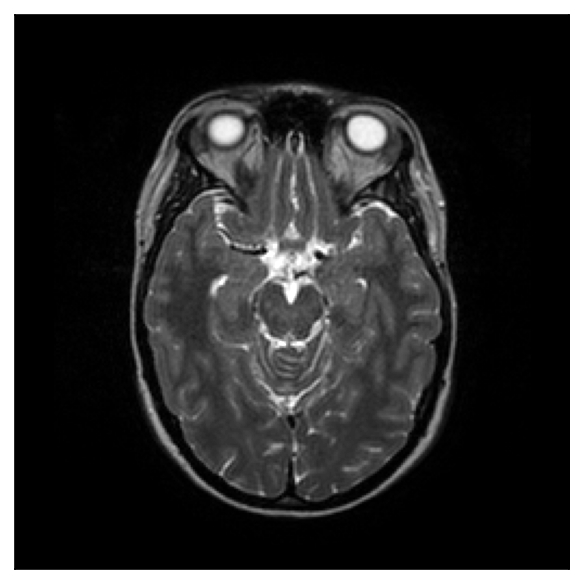

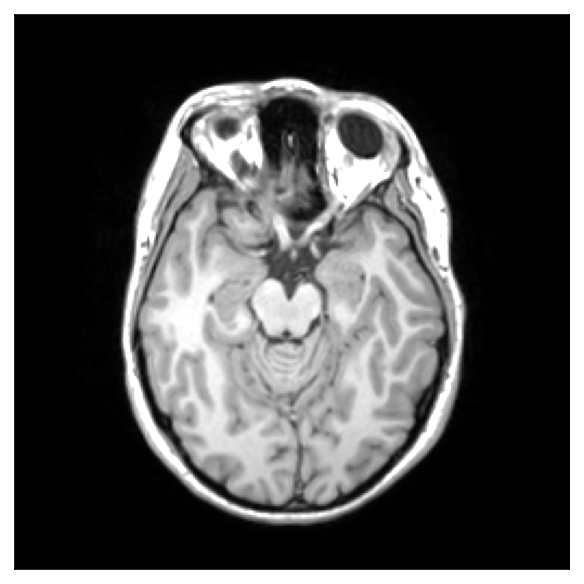

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


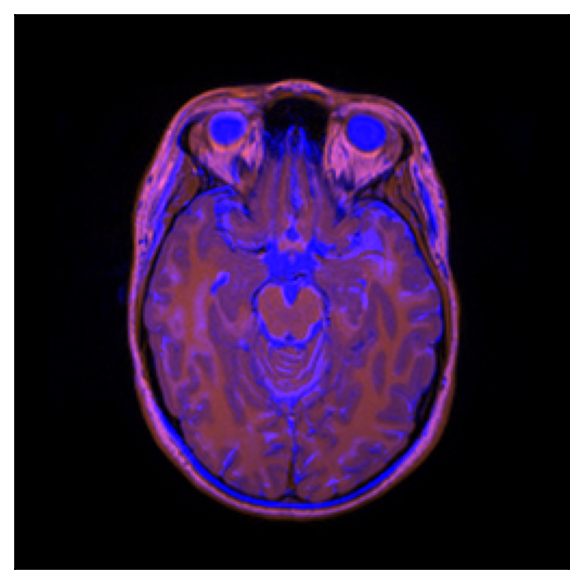

In [42]:
torch.manual_seed(123)
elastic_transform = tio.transforms.RandomElasticDeformation(
    num_control_points=9,  # 제어점의 수 설정
    max_displacement=10,  # 최대 이동 범위 설정 5
)

tmp1 = np.expand_dims(T1_data.copy(), axis=0)
tmp2 = np.expand_dims(T2_data.copy(), axis=0)

elastic_T1 = elastic_transform(tmp1).squeeze()
elastic_T2 = elastic_transform(tmp2).squeeze()

residual_T2 = np.zeros((256, 256, 910))
residual_T2 = abs(T2_data - elastic_T2)

blended_image = np.zeros((256, 256, 3))
blended_image[:, :, 0] = T1_data[:,:,zz]*0.7/150
blended_image[:, :, 1] = T1_data[:,:,zz]*0.3/150
blended_image[:, :, 2] = elastic_T2[:,:,zz]/150 + residual_T2[:,:,zz]/150

show_T2(T2_data[:,:,zz])
show_T1(elastic_T1[:,:,zz])
show_T2(blended_image)

### 3T 7T

In [ ]:
# dataroot = 'C:/Users/NUGURI/Workspace/2023.08.22_misalign_CBM/logs/Model_proposed_A_to_B_Data_Split_3T1_7T1_Misalign_X0_Y5_R2.5_M0_D0/RW_CX_100_5_100_lv5_3T1_7T1_s/runs/2023-08-24_11-55-34/results/a_2.nii.gz'
# nii_img = nib.load(dataroot)
# T1_data = nii_img.get_fdata()
# T1_data = np.transpose(T1_data, (1,0,2))
# T1_data = np.flipud(T1_data)
# T1_data = np.fliplr(T1_data)

# dataroot = 'C:/Users/NUGURI/Workspace/2023.08.22_misalign_CBM/logs/Model_proposed_A_to_B_Data_Split_3T1_7T1_Misalign_X0_Y5_R2.5_M0_D0/RW_CX_100_5_100_lv5_3T1_7T1_s/runs/2023-08-24_11-55-34/results/b_2.nii.gz'
# nii_img = nib.load(dataroot)
# T2_data = nii_img.get_fdata()
# T2_data = np.transpose(T2_data, (1,0,2))
# T2_data = np.flipud(T2_data)
# T2_data = np.fliplr(T2_data)

# test_dataroot = 'C:/Users/NUGURI/Workspace/2023.08.22_misalign_CBM/logs/Model_proposed_A_to_B_Data_Split_3T1_7T1_Misalign_X0_Y5_R2.5_M0_D0/RW_CX_100_5_100_lv5_3T1_7T1_s/runs/2023-08-24_11-55-34/results/preds_a_2.nii.gz'  # Proposed T1
# test_dataroot = 'C:/Users/NUGURI/Workspace/2023.08.22_misalign_CBM/logs/Model_pgan_Data_Split_3T1_7T1_Misalign_X0_Y5_R2.5_M0_D0/train/runs/2023-08-24_11-55-21/results/preds_b_2.nii.gz'  # PGAN T1


dataroot = 'C:/Users/NUGURI/Workspace/2023.08.22_misalign_CBM/logs/Model_proposed_A_to_B_Data_Split_3T2_7T2_Misalign_X0_Y5_R2.5_M0_D0/RW_CX_100_5_100_lv5_3T2_7T2_s/runs/2023-08-27_12-43-10/results/a_1.nii.gz'
nii_img = nib.load(dataroot)
T1_data = nii_img.get_fdata()
T1_data = np.transpose(T1_data, (1,0,2))
T1_data = np.flipud(T1_data)
T1_data = np.fliplr(T1_data)

dataroot = 'C:/Users/NUGURI/Workspace/2023.08.22_misalign_CBM/logs/Model_proposed_A_to_B_Data_Split_3T2_7T2_Misalign_X0_Y5_R2.5_M0_D0/RW_CX_100_5_100_lv5_3T2_7T2_s/runs/2023-08-27_12-43-10/results/b_1.nii.gz'
nii_img = nib.load(dataroot)
T2_data = nii_img.get_fdata()
T2_data = np.transpose(T2_data, (1,0,2))
T2_data = np.flipud(T2_data)
T2_data = np.fliplr(T2_data)

# test_dataroot = 'C:/Users/NUGURI/Workspace/2023.08.22_misalign_CBM/logs/Model_proposed_A_to_B_Data_Split_3T2_7T2_Misalign_X0_Y5_R2.5_M0_D0/RW_CX_100_5_100_lv5_3T2_7T2_s/runs/2023-08-27_12-43-10/results/preds_a_1.nii.gz'  # Proposed T2
test_dataroot = 'C:/Users/NUGURI/Workspace/2023.08.22_misalign_CBM/logs/Model_pgan_Data_Split_3T2_7T2_Misalign_X0_Y0_R0_M0_D0/train/runs/2023-08-27_12-38-52/results/preds_b_1.nii.gz'  # PGAN T2
nii_img = nib.load(test_dataroot)
test_data = nii_img.get_fdata()
test_data = np.transpose(test_data, (1,0,2))
test_data = np.flipud(test_data)
test_data = np.fliplr(test_data)

print('data size:', T2_data.shape)
zz = 135 - 1

def show_7T1(img):
    plt.figure(dpi=150)
    im = plt.imshow(img, cmap='gray')
    # cbar = plt.colorbar(im, shrink=0.5)
    im.set_clim(vmin=0, vmax=180)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def show_7T2(img):
    plt.figure(dpi=150)
    im = plt.imshow(img, cmap='gray')
    # cbar = plt.colorbar(im, shrink=0.5)
    im.set_clim(vmin=0, vmax=100)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def show_residual(img):
    plt.figure(dpi=150)
    im = plt.imshow(img, cmap='jet')
    # cbar = plt.colorbar(im, shrink=0.5)
    im.set_clim(vmin=0, vmax=0.5)
    plt.xticks([])
    plt.yticks([])
    plt.show()

norm_target = (T2_data-np.min(T2_data))/(np.max(T2_data)-np.min(T2_data))
norm_synth = (test_data-np.min(test_data))/(np.max(test_data)-np.min(test_data))
residual = abs(abs(norm_target) - abs(norm_synth))

show_T2(T1_data[:,:,zz])
show_7T2(T2_data[:,:,zz])
show_7T2(test_data[:,:,zz])
show_residual(residual[:,:,zz])

In [ ]:
def SSIM_PSNR(base,zz1,zz2,i):
    dataroot = base + 'b_' + str(i) + '.nii.gz'
    nii_img = nib.load(dataroot)
    T1_data = nii_img.get_fdata()
    # T1_data = np.transpose(T1_data, (1,0,2))

    test_dataroot = base + 'preds_b_' + str(i) + '.nii.gz'
    nii_img = nib.load(test_dataroot)
    test_data = nii_img.get_fdata()
    # test_data = np.transpose(test_data, (1,0,2))

    SSIM = compare_ssim(T1_data[:,:,zz1:zz2], test_data[:,:,zz1:zz2], data_range=T1_data[:,:,zz1:zz2].max() - T1_data[:,:,zz1:zz2].min())
    PSNR = compare_psnr(T1_data[:,:,zz1:zz2], test_data[:,:,zz1:zz2], data_range=T1_data[:,:,zz1:zz2].max() - T1_data[:,:,zz1:zz2].min())

    return SSIM, PSNR

In [ ]:
def SSIM_PSNR(base,zz1,zz2,i):
    dataroot = base + 'b_' + str(i) + '.nii.gz'
    nii_img = nib.load(dataroot)
    T1_data = nii_img.get_fdata()
    # T1_data = np.transpose(T1_data, (1,0,2))

    test_dataroot = base + 'preds_b_' + str(i) + '.nii.gz'
    nii_img = nib.load(test_dataroot)
    test_data = nii_img.get_fdata()
    # test_data = np.transpose(test_data, (1,0,2))

    SSIM = compare_ssim(T1_data[:,:,120], test_data[:,:,120], data_range=T1_data[:,:,120].max() - T1_data[:,:,120].min())
    PSNR = compare_psnr(T1_data[:,:,120], test_data[:,:,120], data_range=T1_data[:,:,120].max() - T1_data[:,:,120].min())

    return SSIM, PSNR

In [ ]:
import lpips
def cal_LPIPS(base,zz1,zz2,i):
    dataroot = base + 'b_' + str(i) + '.nii.gz'
    im1 = nib.load(dataroot)
    T1_data = im1.get_fdata()
    # T1_data = np.transpose(T1_data, (1,0,2))

    test_dataroot = base + 'preds_b_' + str(i) + '.nii.gz'
    im2 = nib.load(test_dataroot)
    test_data = im2.get_fdata()
    # test_data = np.transpose(test_data, (1,0,2))

    loss_fn = lpips.LPIPS(net='alex')
    # image1_tensor = torch.from_numpy(np.squeeze(T1_data[:,:,zz1].astype(np.float32)))
    # image2_tensor = torch.from_numpy(np.squeeze(test_data[:,:,zz1].astype(np.float32)))
    LPIPS = []

    for ii in range(zz1,zz2+1):
        image1_tensor = torch.from_numpy(np.squeeze(T1_data[:,:,ii].astype(np.float32)))
        image2_tensor = torch.from_numpy(np.squeeze(test_data[:,:,ii].astype(np.float32)))
        LPIPS.append(loss_fn.forward(image1_tensor, image2_tensor))
    return sum(LPIPS) / len(LPIPS)

In [ ]:
base = 'C:/Users/NUGURI/Workspace/2023.08.22_misalign_CBM/logs/Model_pgan_Data_Split_3T1_7T1_Misalign_X0_Y5_R2.5_M0_D0/train/runs/2023-08-24_11-55-21/results/'
zz = 120 - 1
# T1-T2 20~80
# 3T-7T 120~180
zz1 = 120-1
zz2 = 120-1

for i in range(1,3):
    SSIM, PSNR = SSIM_PSNR(base,zz1,zz2,i)
    LPIPS = cal_LPIPS(base,zz1,zz2,i)
    print(PSNR, SSIM, LPIPS)

dataroot = base + 'b_1.nii.gz'
nii_img = nib.load(dataroot)
T1_data = nii_img.get_fdata()
# T1_data = np.transpose(T1_data, (1,0,2))

test_dataroot = base + 'preds_b_1.nii.gz'
nii_img = nib.load(test_dataroot)
test_data = nii_img.get_fdata()
# test_data = np.transpose(test_data, (1,0,2))

show_T1(T1_data[:,:,zz])
show_T1(test_data[:,:,zz])

## Table2 Figure

In [ ]:
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

def define_metrics(base,zz1,zz2,i):
    dataroot = base + 'b_' + str(i) + '.nii.gz'
    nii_img = nib.load(dataroot)
    T1_data = nii_img.get_fdata()
    T1_data = np.transpose(T1_data, (1,0,2))

    test_dataroot = base + 'preds_a_' + str(i) + '.nii.gz'
    nii_img = nib.load(test_dataroot)
    test_data = nii_img.get_fdata()
    test_data = np.transpose(test_data, (1,0,2))

    T1_data = torch.tensor(T1_data)
    test_data = torch.tensor(test_data)

    cal_psnr = PeakSignalNoiseRatio()
    cal_ssim = StructuralSimilarityIndexMeasure()
    cal_lpips = LearnedPerceptualImagePatchSimilarity(net_type='vgg')

    psnr = cal_psnr(T1_data, test_data)

    T1_data = T1_data.unsqueeze(1)
    test_data = test_data.unsqueeze(1)
    
    ssim = cal_ssim(T1_data, test_data)

    T1_data = T1_data.repeat(1,3,1,1)
    test_data = test_data.repeat(1,3,1,1)
    lpips = cal_lpips(T1_data.float(), test_data.float())
    
    return psnr, ssim, lpips

In [ ]:
base = 'C:/Users/NUGURI/Desktop/Model_proposed_A_to_B_Data_IXI_Misalign_X0_Y5_R2.5_M0_D0/Proposed_100_5_100_120_lv5_T1/runs/2023-08-12_15-39-24/results/'
zz = 80 - 1
zz1 = 1-1
zz2 = 92-1

for i in range(1,11):
    tmp1, tmp2, tmp3 = define_metrics(base,zz1,zz2,i)
    print(tmp1, tmp2, tmp3)

dataroot = base + 'b_1.nii.gz'
nii_img = nib.load(dataroot)
T1_data = nii_img.get_fdata()
T1_data = np.transpose(T1_data, (1,0,2))

test_dataroot = base + 'preds_a_1.nii.gz'
nii_img = nib.load(test_dataroot)
test_data = nii_img.get_fdata()
test_data = np.transpose(test_data, (1,0,2))

show_T2(T1_data[:,:,zz])
show_T2(test_data[:,:,zz])